# Imports

In [1]:
import pandas as pd
import numpy as np
from plotly import graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import prince
from scipy.stats import chi2_contingency                                                                         
import statsmodels.api as sm

In [2]:
colors = px.colors.qualitative.Plotly

In [3]:
# Create plot layout
layout = go.Layout(
    width=1000,
    height=500,
    template="plotly_white",
    font=dict(
        color="black",
        size=24,
        family="Arial",
    ),
)

# Read files

In [4]:
df = pd.read_excel("../data/06_model_output/output_keywording.xlsx")
df

,entry,database,title,abstract,author_keywords,authors,authors_affiliations,publication_year,source_title,publisher,...,RQ1_PubYear,RQ1_EstimatedPubDate,RQ2_ResearchType,RQ3_ResearchMethod,RQ4_OrganizationType,RQ5_SubtopicsAM,RQ6_SubtopicsDS,RQ7_ProblemsReported,RQ8_ObjectiveAM,RQ9_ContributionsResults
0,6,acm,A Scalable Methodology to Guide Student Teams ...,This article reports on a sequential mixed-met...,"project methodologies, Project-based learning,...","Saltz JS,Heckman RR",NaN,2018.0,ACM Trans. Comput. Educ.,Association for Computing Machinery,...,2018,2018-07-11,Validação,MixedMethods,Academia,Kanban,CicloDesenvolvimento;Geral,Time;Integração;Definição;Incerteza,Definição,Coordenação;Clareza
1,14,ieeex,Achieving Agile Big Data Science: The Evolutio...,While there has been a rapid increase in the u...,Big Data Science;Agile;Process Methodology,J. S. Saltz; I. Shamshurin,School of Information Studies Syracuse Univers...,2019.0,2019 IEEE International Conference on Big Data...,IEEE,...,2019,2019-12-12,Avaliação,Etnografia,Industria,Kanban,BigData,Time;Integração;Incerteza,Agilidade;Integração,Coordenação;Priorização;Eficiência;WIP
2,15,ieeex,SKI: An Agile Framework for Data Science,This paper explores data science project manag...,Data Science;Big Data;Agile;Process Methodology,J. Saltz; A. Suthrland,Syracuse University; Scrum Inc.,2019.0,2019 IEEE International Conference on Big Data...,IEEE,...,2019,2019-12-12,Validação,StudyCase,Academia,Adaptada,CicloDesenvolvimento;Geral,Incerteza;Suporte;Experiência,Definição,Clareza;Divisão;Coordenação
3,18,ieeex,Identifying the most Common Frameworks Data Sc...,This paper presents the results of a study foc...,Data Science;Big Data;Process Methodology,J. S. Saltz; N. Hotz,Syracuse University; Indiana University,2020.0,2020 IEEE International Conference on Big Data...,IEEE,...,2020,2020-12-13,Avaliação,Survey,Industria,Geral,CicloDesenvolvimento;Geral,Definição,NaN,NaN
4,20,ieeex,Applying Scrum in Data Science Projects,The rise of big data has led to an increase in...,Data Science;Agile;Scrum,J. Baijens; R. Helms; D. Iren,"Department of Information Science, Open Univer...",2020.0,2020 IEEE 22nd Conference on Business Informat...,IEEE,...,2020,2020-06-24,Avaliação,Interview,Industria,Adaptada,CicloDesenvolvimento;Geral,Incerteza;Definição,Agilidade;Definição,Clareza;Coordenação;Priorização
5,21,ieeex,Managing and Composing Teams in Data Science: ...,Data science projects have become commonplace ...,Data science;agile practices;teamwork;project ...,T. Aho; T. Kilamo; L. Lwakatare; T. Mikkonen; ...,"TietoEvry, Tampere, Finland; Computing Science...",2021.0,2021 IEEE International Conference on Big Data...,IEEE,...,2021,2021-12-18,Avaliação,Survey,Organizações,Geral,BigData,Incerteza,NaN,NaN
6,22,ieeex,Using Agile Frameworks in Big Data projects,Considering the main problems of Big Data proj...,Agile;project management;Big Data;statistics;q...,K. Kolesnikova; O. Mezentseva; O. Kolesnikov; ...,"Taras Shevchenko National University of Kyiv, ...",2021.0,2021 IEEE 16th International Conference on Com...,IEEE,...,2021,2021-09-25,Avaliação,Survey,Industria,Geral,BigData,Escolha;Suporte;Experiência,Agilidade;Integração,Eficiência
7,24,ieeex,Story and Task Issue Analysis for Agile Machin...,The usage of Agile methodology in planning and...,scrum;machine learning project;software engine...,K. Singla; T. M. Vinayak; A. S. Arpitha; C. Na...,"Samsung R&D Institute, Bangalore, India; Samsu...",2020.0,2020 IEEE-HYDCON,IEEE,...,2020,2020-09-11,Avaliação,FieldStudy,Industria,Scrum,ML,Especificidades,Agilidade,NaN
8,28,ieeex,"CRISP-DM for Data Science: Strengths, Weakness...",This paper explores the strengths and weakness...,NaN,J. S. Saltz,Syracuse University,2021.0,2021 IEEE International Conference on Big Data...,IEEE,...,2021,2021-12-18,Solução,Proposta,Geral,Adaptada,CicloDesenvolvimento;Geral,Time;Integração;Definição,Definição;Integração,NaN
9,29,ieeex,Identifying and Addressing 6 Key Questions

In [5]:
df.columns

Index(['entry', 'database', 'title', 'abstract', 'author_keywords', 'authors',
       'authors_affiliations', 'publication_year', 'source_title', 'publisher',
       'doi', 'query_date', 'processing_date', 'duplicated_exclusion_flag',
       'duplicated_validation_date', 'metadata_exclusion_flag',
       'metadata_exclusion_criteria', 'metadata_validation_date',
       'fulltext_exclusion_flag', 'fulltext_exclusion_criteria',
       'fulltext_validation_date', 'exclusion_step', 'exclusion_criteria',
       'exclusion_date', 'RQ0_Authors', 'RQ0_Countries', 'RQ0_ScopusCitations',
       'RQ0_FWCI', 'RQ0_Keywords', 'RQ1_PubSourceType',
       'RQ1_MacroPubSourceType', 'RQ1_PubSourceName', 'RQ1_ShortPubSourceName',
       'RQ1_PubYear', 'RQ1_EstimatedPubDate', 'RQ2_ResearchType',
       'RQ3_ResearchMethod', 'RQ4_OrganizationType', 'RQ5_SubtopicsAM',
       'RQ6_SubtopicsDS', 'RQ7_ProblemsReported', 'RQ8_ObjectiveAM',
       'RQ9_ContributionsResults'],
      dtype='object')

# Data Processing

In [6]:
categorical_cols = ["RQ2_ResearchType", "RQ3_ResearchMethod", "RQ4_OrganizationType", "RQ5_SubtopicsAM"]
pre_process_categorical_cols = ['RQ6_SubtopicsDS', 'RQ7_ProblemsReported', 'RQ8_ObjectiveAM', 'RQ9_ContributionsResults']

In [7]:
df_agg = df.copy()
df_agg = df_agg.set_index("entry")[categorical_cols]

for col in ["RQ6_SubtopicsDS", "RQ9_ContributionsResults"]:

    df_process = df.copy()
    df_process = df_process.set_index("entry")
    df_process = df_process[col].str.split(";", expand = True)
    df_process = pd.melt(df_process.reset_index(), id_vars = "entry", value_vars = [col for col in df_process.columns if col != "entry"], value_name = col)
    df_process = df_process.dropna()
    df_process = df_process[["entry", col]]
    df_process[col] = df_process[col].str.replace(" ", "_").str.lower().str.capitalize()
    
    
    if col == "RQ6_SubtopicsDS":
        df_topics = df_process[df_process[col] != "Ciclodesenvolvimento"]
        df_topics = df_topics.set_index("entry").sort_index()
        df_topics.columns = ["RQ6_SubareasDS"]
        df_others = df_process[df_process[col] == "Ciclodesenvolvimento"]
        df_process = df_topics.merge(df_others, on = "entry", how = "outer").set_index("entry")
        df_process = df_process.fillna(0).replace("Ciclodesenvolvimento", 1)    
    
    else:
        df_process = pd.get_dummies(df_process, columns=[col])
        df_process = df_process.groupby("entry").sum()
        df_entry = pd.DataFrame(index = df["entry"])
        df_process = df_process.merge(df_entry, how = "outer", on = ["entry"]).sort_index()
        df_process = df_process.fillna(0)
        if col != "RQ7_ProblemsReported":
            df_process[col] = np.where(df_process.sum(axis = 1) >= 1, 1, 0)
            df_process = df_process[[col]]
    df_process = df_process.replace(1, "Sim").replace(0, "Não")
        
    df_agg = df_agg.merge(df_process, how = "left", on = "entry")
df_agg = df_agg[["RQ4_OrganizationType", "RQ5_SubtopicsAM"]]
df_agg.columns = ["RQ4", "RQ5"]
df_agg["RQ5"] = df_agg["RQ5"].replace("Geral", "Agile em geral")
df_agg

,RQ4,RQ5
entry,,
6,Academia,Kanban
14,Industria,Kanban
15,Academia,Adaptada
18,Industria,Agile em geral
20,Industria,Adaptada
21,Organizações,Agile em geral
22,Industria,Agile em geral
24,Industria,Scrum
28,Geral,Adaptada


# MCA

In [8]:
pval_ref_val = 0.05
residuals_ref_val = 1.96
significance_table = pd.DataFrame()

for i in range(0, len(df_agg.columns)):
    for j in range(i+1, len(df_agg.columns)):

        var1 = df_agg.columns[i]
        var2 = df_agg.columns[j]
        
        tabela_mca = pd.crosstab(df_agg[var1], df_agg[var2])
        chi2, pvalor, degfreed, freq_esp = chi2_contingency(tabela_mca)
        F = np.array(tabela_mca)
        table = sm.stats.Table(F)                                                                                    
        standardized_resids = pd.DataFrame(table.standardized_resids, index = tabela_mca.index, columns = tabela_mca.columns)
        statistical_significance = pvalor < pval_ref_val
        display(pvalor)
        display(statistical_significance)
        display(standardized_resids)
        display(standardized_resids>residuals_ref_val)


0.24018298986252373

False

RQ5,Adaptada,Agile em geral,Kanban,Scrum
RQ4,,,,
Academia,-0.486374,-0.706591,1.858906,-0.413558
Geral,0.155710,-0.252825,0.097477,0.000000
Industria,0.647382,-0.191118,-1.252652,0.633866
Organizações,-0.486374,1.163797,-0.304476,-0.413558


RQ5,Adaptada,Agile em geral,Kanban,Scrum
RQ4,,,,
Academia,False,False,False,False
Geral,False,False,False,False
Industria,False,False,False,False
Organizações,False,False,False,False


In [9]:
expected_counts = pd.DataFrame(index = tabela_mca.index, columns = tabela_mca.columns)

for row in expected_counts.index:
    for col in expected_counts.columns:
        row_count = (tabela_mca.loc[row].sum())
        col_count = (tabela_mca[col].sum())
        total_count = (tabela_mca.sum().sum())

        expected_count = (row_count*col_count)/total_count
        
        expected_counts.loc[row, col] = expected_count.round(2)

expected_counts

RQ5,Adaptada,Agile em geral,Kanban,Scrum
RQ4,,,,
Academia,1.26,0.79,0.47,0.47
Geral,0.42,0.26,0.16,0.16
Industria,5.05,3.16,1.89,1.89
Organizações,1.26,0.79,0.47,0.47


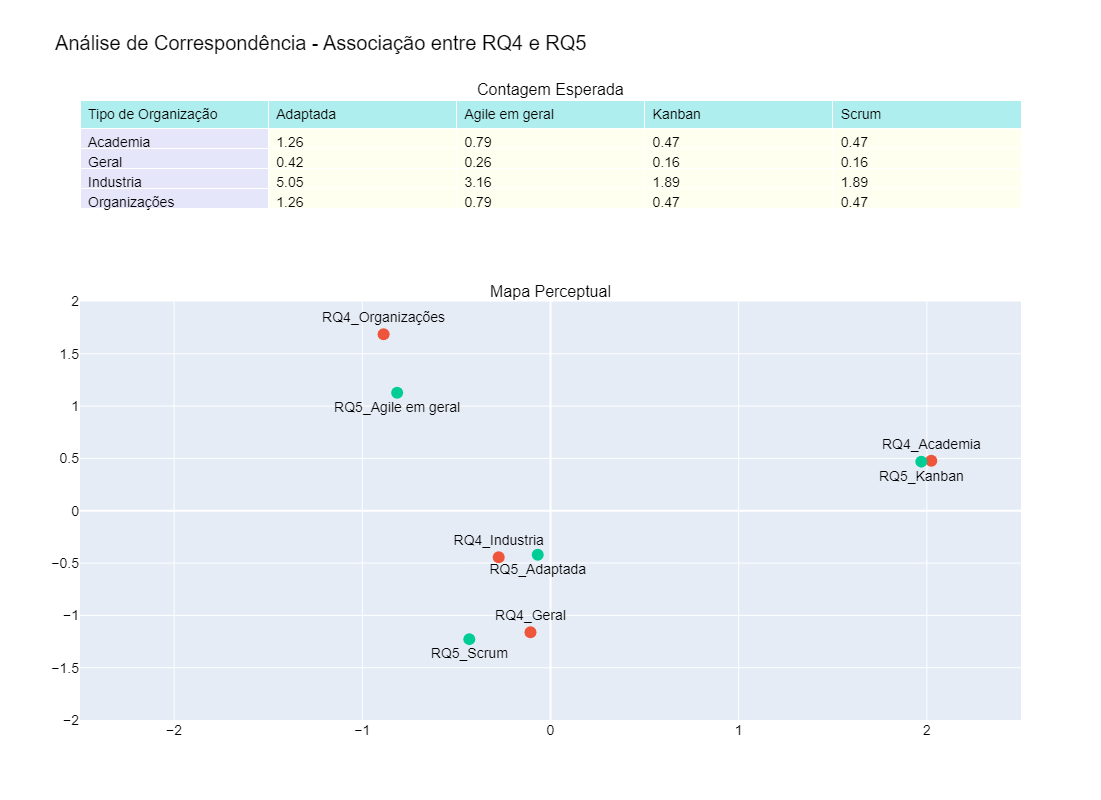

In [15]:
fig = make_subplots(
    rows=2, cols=1,  
    vertical_spacing = 0.1,
    subplot_titles=['Contagem Esperada', 'Mapa Perceptual'], 
    specs=[[{"type": "table"}], [{"type": "scatter"}]],
    row_heights=[0.25, 0.75]
)

fig.add_trace(go.Table(
    header=dict(values=["Tipo de Organização"]+list(expected_counts.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=expected_counts.reset_index().T.values,
               fill_color=np.select(
                [
                    expected_counts.reset_index().T.values == "Academia", 
                    expected_counts.reset_index().T.values == "Geral", 
                    expected_counts.reset_index().T.values == "Industria", 
                    expected_counts.reset_index().T.values == "Organizações", 
                ],
                [
                    "lavender",
                    "lavender",
                    "lavender",
                    "lavender",
                ],
                "ivory",
            ),
            align='left')),  
    row=1, col=1
)

df_filt = df_agg.copy()

#%% Elaborando a MCA 
## Utiliza o método da matriz de Burt
mca = prince.MCA()
mca = mca.fit(df_filt)

col_coordinates = mca.column_coordinates(df_filt)
row_coordinates = mca.row_coordinates(df_filt)

ind_cols = col_coordinates.index

chart_df = pd.DataFrame({
    'obs_x':row_coordinates[0],
    'point':row_coordinates.index,
    'obs_y': row_coordinates[1]
})
    
for col in df_filt.columns:
    col_ind = [ind for ind in ind_cols if col in ind]

    text_position = "top center" if col == "RQ4" else "bottom center"

    fig.add_trace(go.Scatter(
        x=col_coordinates.loc[col_ind][0],
        mode='markers+text',
        name=col,
        marker={'size':12},
        y=col_coordinates.loc[col_ind][1],
        textposition=text_position,
        text=col_coordinates.loc[col_ind].index,
        showlegend=False
    ),
    row=2, col=1
)

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    title=dict(text = 'Análise de Correspondência - Associação entre RQ4 e RQ5', font = dict(size=20)),
    font=dict(
        color="black",
        size=14,
        family="Arial",
    ),
    xaxis = dict(range=[-2.5, 2.5]),
    yaxis = dict(range=[-2.0, 2.0]),

)
fig.show()